In [1]:
%load_ext autoreload
%autoreload 2

# Imports and Setup

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import scipy
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import gaussian_kde
# import seaborn as sns # v 0.11.0
import os
# import h5py
import numpy as np
from astropy import units as u, constants as const

In [3]:
###### # Setup Plotting Defaults #
###################################### ##
# For more options see https://matplotlib.org/users/customizing.html

from cycler import cycler

import os
os.environ["PATH"] += os.pathsep + '/global/software/sl-7.x86_64/modules/tools/texlive/2016/bin/x86_64-linux/'

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.epi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 16, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

mpl.rcParams['text.usetex'] = False

# Rescale Limits

In [4]:
comptel_arr = np.loadtxt('../data/CGRO/tau_comptel.csv', delimiter=',')
m_comptel = comptel_arr[:,0] * 1e6 # eV
tau_comptel = comptel_arr[:,1] # s

comptel_flux = np.loadtxt('../data/CGRO/flux_mean_comptel.csv', delimiter=',')
m_temp1 = comptel_flux[:,0] * 1e6 # eV
mean_flux_comptel = comptel_flux[:,1] # MeV/cm^2/s/sr
mean_flux_comptel_interp = scipy.interpolate.interp1d(m_temp1, mean_flux_comptel, kind='linear', fill_value=(mean_flux_comptel[0], mean_flux_comptel[-1]), bounds_error=False)

comptel_upper = np.loadtxt('../data/CGRO/flux_upper_comptel.csv', delimiter=',')
m_temp2 = comptel_upper[:,0] * 1e6 # eV
upper_flux_comptel = comptel_upper[:,1] # MeV/cm^2/s/sr
upper_flux_comptel_interp = scipy.interpolate.interp1d(m_temp2, upper_flux_comptel, kind='linear', fill_value=(upper_flux_comptel[0], upper_flux_comptel[-1]), bounds_error=False)
print(mean_flux_comptel)
print(upper_flux_comptel)
error_comptel = lambda m: upper_flux_comptel_interp(m) - mean_flux_comptel_interp(m)
update_factor_comptel = lambda m: (mean_flux_comptel_interp(m) + 2 * error_comptel(m)) / (1.64 * error_comptel(m))


# same for egret
egret_arr = np.loadtxt('../data/CGRO/tau_egret.csv', delimiter=',')
m_egret = egret_arr[:,0] * 1e6 # eV
tau_egret = egret_arr[:,1] # s

egret_flux = np.loadtxt('../data/CGRO/flux_mean_egret.csv', delimiter=',')
m_temp1 = egret_flux[:,0] * 1e6 # eV
mean_flux_egret = egret_flux[:,1] # MeV/cm^2/s/sr
mean_flux_egret_interp = scipy.interpolate.interp1d(m_temp1, mean_flux_egret, kind='linear', fill_value=(mean_flux_egret[0], mean_flux_egret[-1]), bounds_error=False)

egret_upper = np.loadtxt('../data/CGRO/flux_upper_egret.csv', delimiter=',')
m_temp2 = egret_upper[:,0] * 1e6 # eV
upper_flux_egret = egret_upper[:,1] # MeV/cm^2/s/sr
upper_flux_egret_interp = scipy.interpolate.interp1d(m_temp2, upper_flux_egret, kind='linear', fill_value=(upper_flux_egret[0], upper_flux_egret[-1]), bounds_error=False)

error_egret = lambda m: upper_flux_egret_interp(m) - mean_flux_egret_interp(m)
update_factor_egret = lambda m: (mean_flux_egret_interp(m) + 2 * error_egret(m)) / (1.64 * error_egret(m))


comptel_arr_actual = np.loadtxt('../data/CGRO/tau_comptel_actual.csv', delimiter=',')
m_comptel_actual = comptel_arr_actual[:,0] * 1e6 # eV
tau_comptel_actual = comptel_arr_actual[:,1] # s

egret_arr_actual = np.loadtxt('../data/CGRO/tau_egret_actual.csv', delimiter=',')
m_egret_actual = egret_arr_actual[:,0] * 1e6 # eV
tau_egret_actual = egret_arr_actual[:,1] # s


[0.00307794 0.0030256  0.00413892 0.00193027 0.0012317  0.00108451
 0.00143416 0.00158742 0.0009709 ]
[0.00566508 0.00462176 0.00566293 0.00315536 0.00199645 0.00180312
 0.00181818 0.00204687 0.0015342 ]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


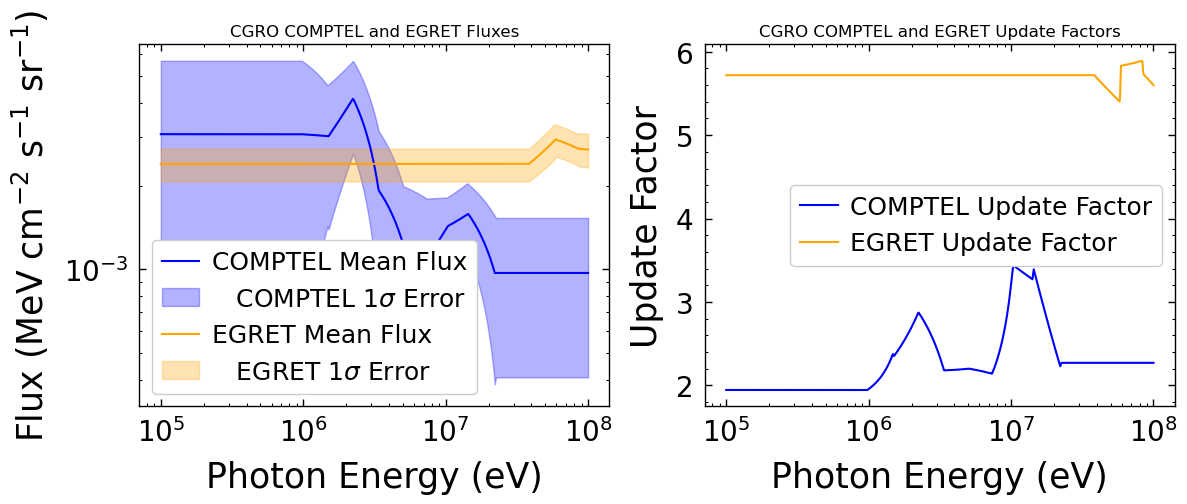

In [5]:
# plot fluxes and errors and update factors
m_vals = np.logspace(5, 8, 1000) # eV
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(m_vals, mean_flux_comptel_interp(m_vals), label='COMPTEL Mean Flux', color='blue')
plt.fill_between(m_vals, mean_flux_comptel_interp(m_vals) - error_comptel(m_vals), mean_flux_comptel_interp(m_vals) + error_comptel(m_vals), color='blue', alpha=0.3, label='   COMPTEL 1$\sigma$ Error')
plt.loglog(m_vals, mean_flux_egret_interp(m_vals), label='EGRET Mean Flux', color='orange')
plt.fill_between(m_vals, mean_flux_egret_interp(m_vals) - error_egret(m_vals), mean_flux_egret_interp(m_vals) + error_egret(m_vals), color='orange', alpha=0.3, label='   EGRET 1$\sigma$ Error')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Flux (MeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.title('CGRO COMPTEL and EGRET Fluxes')
plt.legend()
plt.subplot(1,2,2)
plt.semilogx(m_vals, update_factor_comptel(m_vals), label='COMPTEL Update Factor', color='blue')
plt.semilogx(m_vals, update_factor_egret(m_vals), label='EGRET Update Factor', color='orange')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Update Factor')
plt.title('CGRO COMPTEL and EGRET Update Factors')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Limits

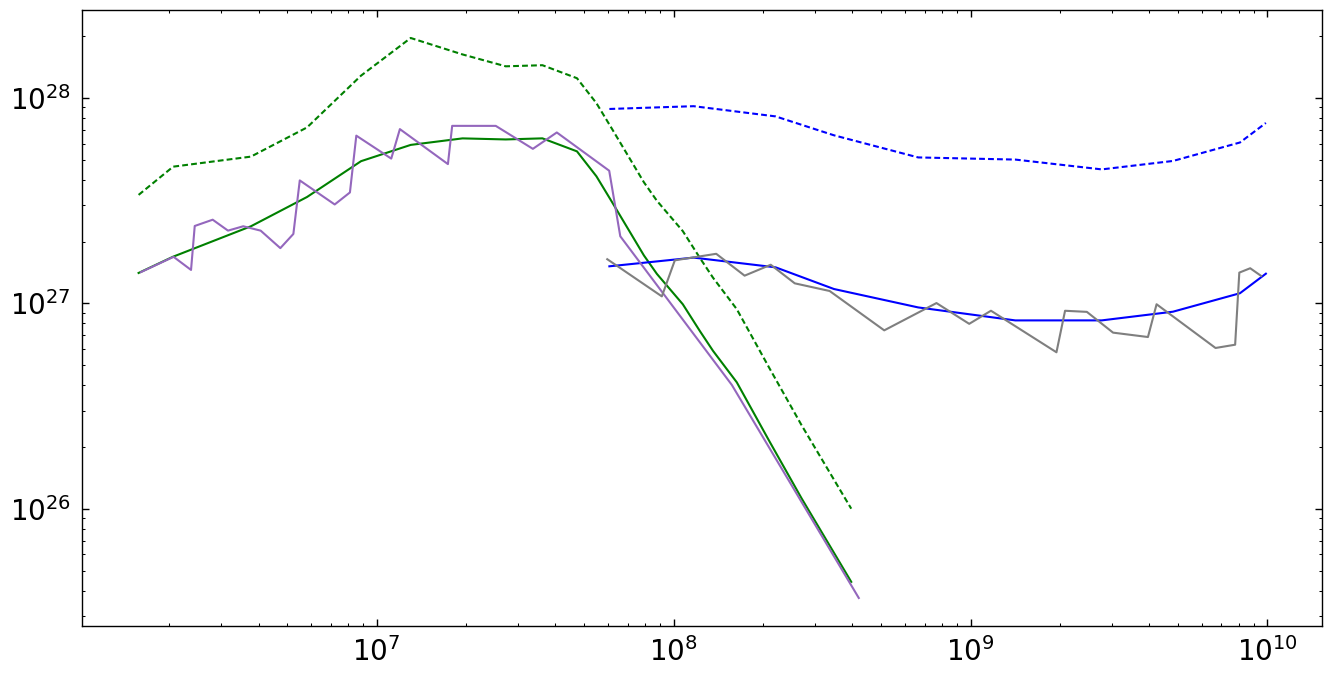

In [6]:
plt.plot(m_comptel, tau_comptel, c='g')
plt.plot(m_comptel, tau_comptel * update_factor_comptel(m_comptel), c='g', ls='--')
plt.plot(m_egret, tau_egret, c='b')
plt.plot(m_egret, tau_egret * update_factor_egret(m_egret), c='b', ls='--')

plt.plot(m_comptel_actual, tau_comptel_actual, c='tab:purple')
plt.plot(m_egret_actual, tau_egret_actual, c='tab:grey')

plt.xscale('log')
plt.yscale('log')

# Save Limits

In [7]:
limit_dict = {"mDM_eV": m_comptel,
              "tau_limit_arr_s": tau_comptel*update_factor_comptel(m_comptel)
             }
np.save("../projected_limits/"+"Comptel.npy", limit_dict)

limit_dict = {"mDM_eV": m_egret,
              "tau_limit_arr_s": tau_egret*update_factor_egret(m_egret)
             }
np.save("../projected_limits/"+"Egret.npy", limit_dict)

limit_dict = {"mDM_eV": m_comptel_actual,
              "tau_limit_arr_s": tau_comptel_actual
             }
np.save("../existing_limits/"+"Comptel.npy", limit_dict)

limit_dict = {"mDM_eV": m_egret_actual,
              "tau_limit_arr_s": tau_egret_actual
             }
np.save("../existing_limits/"+"Egret.npy", limit_dict)